# **Load, analyse and visualize dataset**

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np
from PIL import Image
import random
import cv2
import os

In [2]:
# Define paths
base_path = "C:/Users/funmi/GitRepositories/Road-Sign-Detection"
training_folder = os.path.join(base_path, 'traffic_Data/TRAIN')
val_folder = os.path.join(base_path, 'traffic_Data/VAL')

# Load labels
labels_df = pd.read_csv(os.path.join(base_path, 'labels.csv'))
print(labels_df)

# Calculate number of classes 
class_names = sorted(labels_df['ClassId'].unique())
num_classes = len(class_names)

# Create mapping bedtween class IDs and names
class_id_to_name = dict(zip(labels_df['ClassId'], labels_df['Name']))


    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

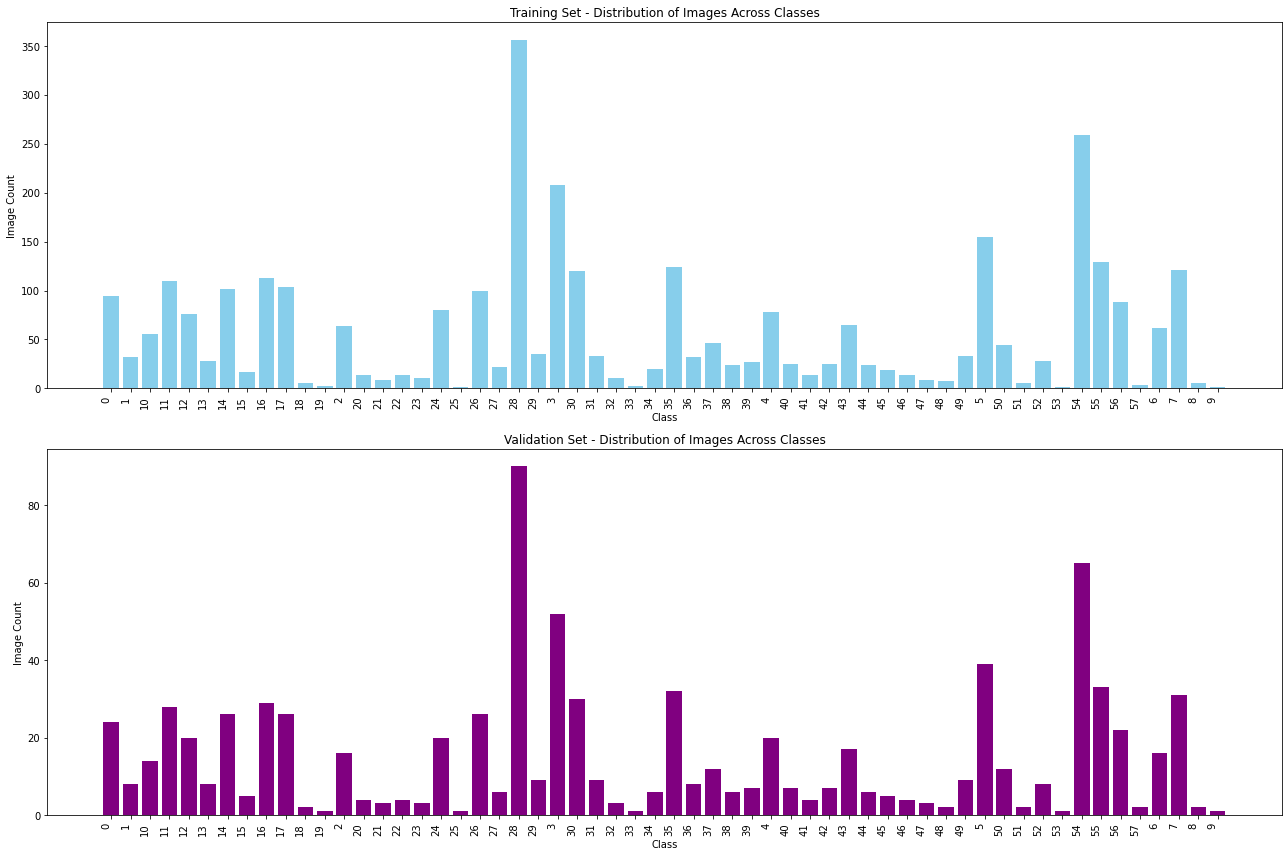

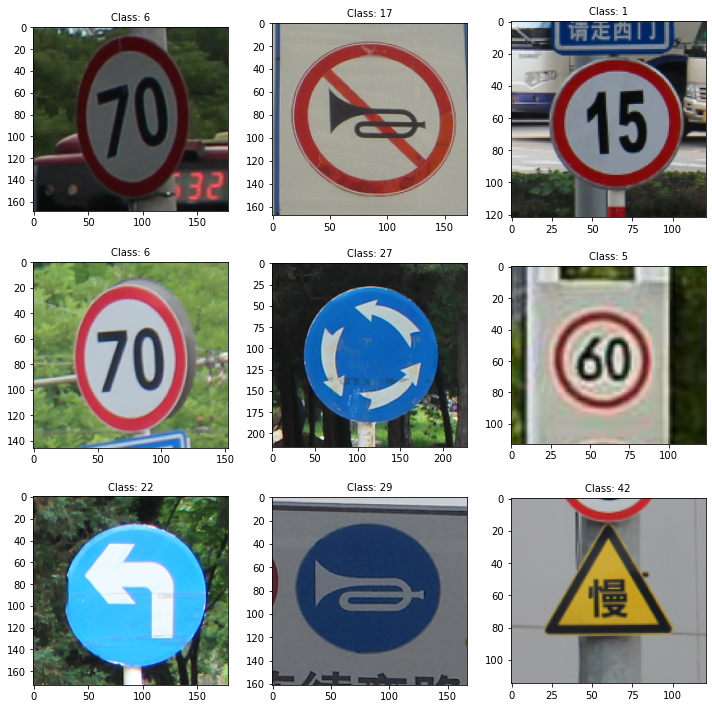

In [3]:
# Examine class distribution in training and validation folders

# Function to get class counts 
def get_class_counts(folder_path):
    class_names =[]
    class_counts = []
    for class_folder in os.listdir(folder_path):
        folder_subpath = os.path.join(folder_path, class_folder)
        if os.path.isdir(folder_subpath):
            class_names.append(class_folder)
            num_images = len(os.listdir(folder_subpath))
            class_counts.append(num_images)
    return class_names, class_counts

# Get folder counts for training and validation folders 
train_folder_names, train_folder_counts = get_class_counts(training_folder)
val_folder_names, val_folder_counts = get_class_counts(val_folder)

# Plot histogram for distribution of classes
plt.figure(figsize=(18,12))

plt.subplot(2 ,1 ,1)
plt.bar(train_folder_names, train_folder_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Training Set - Distribution of Images Across Classes')
plt.xticks(rotation=90, ha='right')

plt.subplot(2 ,1 ,2)
plt.bar(val_folder_names, val_folder_counts, color='purple')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Validation Set - Distribution of Images Across Classes')
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

# Plot random images 
def plot_random_images(folder_path, num_images=9):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        class_folder = random.choice(os.listdir(folder_path))
        image_path = os.path.join(folder_path, class_folder, random.choice(os.listdir(os.path.join(folder_path, class_folder))))
        image = Image.open(image_path)
        plt.subplot(3,3,i + 1)
        plt.imshow(image)
        plt.title(f'Class: {class_folder}', fontsize=10)
        plt.axis('on')
    plt.tight_layout()
    plt.show()

# Plot random images from training set
plot_random_images(training_folder)

# **Preprocessing steps**

In [4]:
# Image dimensions and batch size
image_shape = (75,75)
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, 
                            rotation_range=10, # rotate image by 10 degrees
                            width_shift_range=0.1, # shift images horizontally by 10%
                            height_shift_range=0.1, # shift images vertically by 10%
                            shear_range=0.1, # applies shear transformation
                            zoom_range=0.1,  # zoom image by 10%
                            horizontal_flip=True, # flips horizontally
                            vertical_flip=False, # does not flip image vertically
                            fill_mode='nearest', # fills in newly created pixels using nearest pixel value
                            validation_split=0.2
                            )
val_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training data
train_generator = train_datagen.flow_from_directory(
                            training_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape
                        )

# Generate validation data
validation_generator = val_datagen.flow_from_directory(
                            val_folder,
                            class_mode ='categorical',
                            batch_size = batch_size,
                            target_size = image_shape
                        )

Found 3313 images belonging to 58 classes.
Found 857 images belonging to 58 classes.


In [5]:
batch = next(train_generator)
print(batch[0].shape)

(32, 75, 75, 3)


# **Build a custom model**

In [6]:
# Building CNN Model
noOfFilters=32
sizeOfFilter=(3,3)
imageDimensions = (75,75,3)

model = Sequential()

#input layer
model.add(Conv2D(noOfFilters, sizeOfFilter, padding='same', activation='relu',
                input_shape=imageDimensions))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#First hidden layer
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Second hidden layer
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Third hidden Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [7]:
print(model.summary())
history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size          
          )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        3

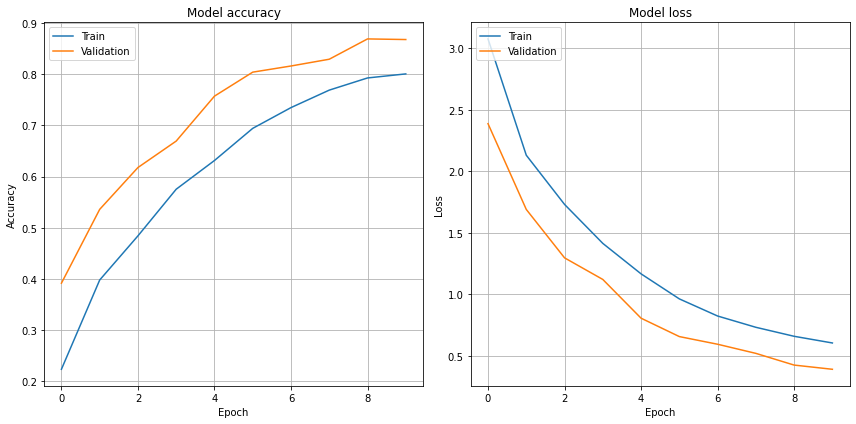

In [8]:
# Plot training history
plt.figure(figsize=(12,6))

# Plot training and validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training and validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# save the entire model
model.save('model.h5')   